In [1]:
import pandas as pd
import glob
import os
import ast

file = "merged_gpt5_MPU.csv"

og_df = pd.read_csv(file)
df = og_df

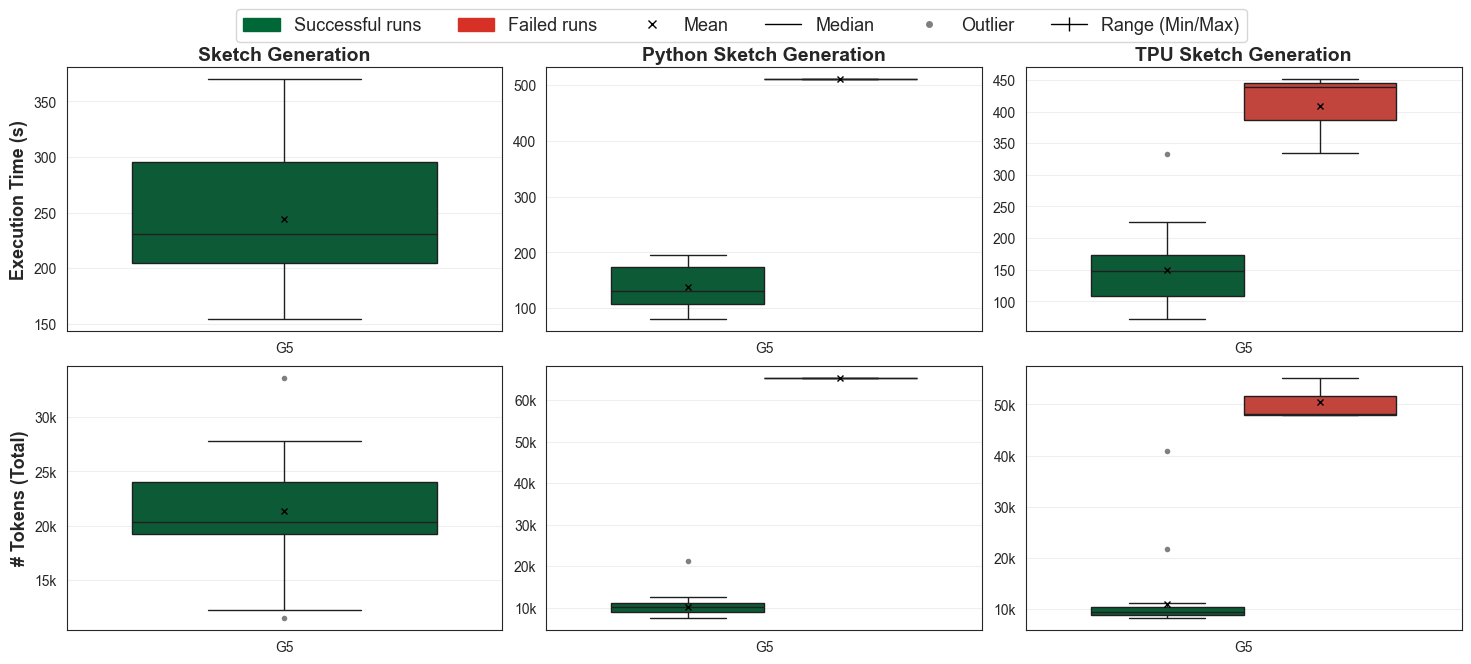

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D  # <--- Added for custom legend handles

# ==========================================
# 1. SETUP & DATA
# ==========================================
# df = pd.read_csv('your_file.csv') 
# ------------------------------------------------------------

# Data Cleaning (Mocking data for the example to run if copied)
if 'df' not in locals():
    # Creating dummy data for visualization purposes since CSV isn't provided
    np.random.seed(42)
    models = ['gpt-5']
    processors = ['sg', 'psg', 'tpusg']
    statuses = ['success', 'failure']
    
    data = []
    for _ in range(300):
        data.append({
            'processor': np.random.choice(processors),
            'model': np.random.choice(models),
            'status': np.random.choice(statuses, p=[0.8, 0.2]),
            'latency': np.random.lognormal(0, 0.5),
            'total_tokens': np.random.randint(100, 5000)
        })
    df = pd.DataFrame(data)

for col in ['processor', 'model', 'status']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

# ==========================================
# 2. CONFIGURATION
# ==========================================
# Mappings
model_map = {
    'gpt-5': 'G5' 
}
proc_titles = {
    'sg': 'Sketch Generation', 'psg': 'Python Sketch Generation', 'tpusg': 'TPU Sketch Generation'
}

# Ordering & Styling
proc_order   = ['sg', 'psg', 'tpusg']
model_order  = list(model_map.values())
 
palette      = {'success': '#006837', 'failure': '#D73027'}

# Apply Map
df['model_display'] = df['model'].map(model_map)

# Metric Configuration
metrics = [
    {'col': 'latency',      'label': 'Execution Time (s)', 'fmt': None},
    {'col': 'total_tokens', 'label': '# Tokens (Total)',   'fmt': lambda x, p: f'{int(x/1000)}k' if x >= 1000 else f'{int(x)}'}
]

# ==========================================
# 3. PLOTTING
# ==========================================
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 7))
plt.subplots_adjust(top=0.915, hspace=0.13, wspace=0.1) # Adjusted top to fit larger legend

for col_idx, proc in enumerate(proc_order):
    subset = df[df['processor'] == proc]
    
    for row_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]
        
        if subset.empty:
            ax.set_visible(False)
            continue

        # 1. Plot
        sns.boxplot(
            data=subset, x='model_display', y=metric['col'], hue='status',
            hue_order=['success', 'failure'], order=model_order,
            ax=ax, palette=palette,
            showmeans=True, 
            meanprops={"marker":"x", "markeredgecolor":"black", "markersize":5},
            flierprops={"marker":"o", "markersize":3, "markerfacecolor":"gray", "markeredgecolor":"gray"}, # Explicit styling for legend matching
            width=0.7, linewidth=1.0
        )
        
        # 2. Clean up
        if ax.get_legend(): ax.get_legend().remove()
        ax.set_xlabel("")
        ax.grid(axis='y', alpha=0.3)
        
        # 3. Styling
        ax.set_ylabel(metric['label'] if col_idx == 0 else "", fontweight='bold', fontsize=13)
        if row_idx == 0:
            ax.set_title(proc_titles.get(proc, proc), fontsize=14,  weight='bold', pad=5)
        if metric['fmt']:
            ax.yaxis.set_major_formatter(FuncFormatter(metric['fmt']))

# ==========================================
# 4. CUSTOM LEGEND
# ==========================================
# Define Custom Legend Elements
# A. Status Rectangles
legend_elements = [
    plt.Rectangle((0,0), 1, 1, color=palette['success'], label='Successful runs'),
    plt.Rectangle((0,0), 1, 1, color=palette['failure'], label='Failed runs'),
]

# B. Statistical Markers (Matching plot props)
legend_elements += [
    Line2D([0], [0], color='black', marker='x', linestyle='None', 
           markersize=6, label='Mean'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', 
           label='Median'), # Default seaborn median line is dark grey/black
    Line2D([0], [0], color='gray', marker='o', linestyle='None', 
           markersize=4, label='Outlier'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', 
           marker='|', markersize=10, label='Range (Min/Max)')
]
# ax.tick_params(axis='both', labelpad=0)  # or axis='x' or axis='y' separately

# Create the Legend
fig.legend(handles=legend_elements, loc='upper center', ncol=6, 
           bbox_to_anchor=(0.5, 1.01), fontsize=13, frameon=True)
plt.savefig("box_MCU.pdf", dpi=300, bbox_inches='tight')
plt.show()
